# Train a Neural Network model for sentiment analysis with imdb dataset and keras

## Load properties

In [71]:
import yaml

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

## Load the dataset

In [72]:
from keras.datasets import imdb
import numpy as np

num_words = config["num_words"]

(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(
    num_words=num_words
)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

## Analyze the dataset

In [73]:
print(f"The output categories are {np.unique(targets)}")
print(f"The number of unique words is {len(np.unique(np.hstack(data)))}")

The output categories are [0 1]
The number of unique words is 69418


Visualize mean and sd

The Average Review length is 234.75892
The Standard Deviation is 172.91149458735703


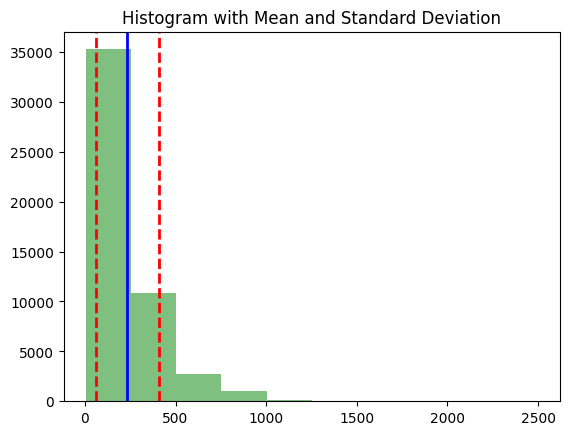

In [74]:
import matplotlib.pyplot as plt

length = [len(i) for i in data]
mean = np.mean(length)
std = np.std(length)
print(f"The Average Review length is {mean}")
print(f"The Standard Deviation is {std}")

# create histogram
plt.hist(length, bins=10, alpha=0.5, color="g")

# add a vertical line for the mean
plt.axvline(mean, color="blue", linestyle="solid", linewidth=2)

# add vertical lines for one standard deviation above and below the mean
plt.axvline(x=(mean + std), color="red", linestyle="dashed", linewidth=2)
plt.axvline(x=(mean - std), color="red", linestyle="dashed", linewidth=2)

plt.title("Histogram with Mean and Standard Deviation")
plt.show()

todo

In [75]:
index = imdb.get_word_index()
reverse_index = dict([(value, key) for (key, value) in index.items()])
decoded = " ".join([reverse_index.get(i - 3, "#") for i in data[0]])
print(decoded)

# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

## Prepare data for training

In [76]:
def vectorize(sequences: np.ndarray, dimension=num_words) -> np.ndarray:
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1
    return results


data = vectorize(data)
targets = np.array(targets).astype("float32")

Split data into train and test

In [77]:
from sklearn.model_selection import train_test_split

test_size = config["model"]["training"]["test_size"]
random_state = config["model"]["training"]["random_state"]

train_x, test_x, train_Y, test_Y = train_test_split(data, targets, test_size=test_size, random_state=random_state)

## Build and traing the neuronal network

Create sequential model

In [78]:
from keras import models

model = models.Sequential()

In [79]:
from keras import layers

activation = config["model"]["training"]["activation_function"]

# Input - Layer
model.add(layers.Dense(units=50, activation=activation, input_shape=(num_words,)))
# Hidden - Layers
model.add(layers.Dropout(rate=0.3, noise_shape=None, seed=None))
model.add(layers.Dense(units=50, activation=activation))
model.add(layers.Dropout(rate=0.2, noise_shape=None, seed=None))
model.add(layers.Dense(units=50, activation=activation))
# Output- Layer
model.add(layers.Dense(units=1, activation="sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 50)                3471050   
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3476201 (13.26 MB)
Trainable params: 347

Compile the model

In [80]:
optimizer = config["model"]["compile"]["optimizer"]
loss = config["model"]["compile"]["loss_function"]
metrics = config["model"]["compile"]["metrics"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Train the model

In [81]:
epochs = config["model"]["training"]["epochs"]
batch_size = config["model"]["training"]["batch_size"]

results = model.fit(
    train_x, train_Y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_Y)
)

Epoch 1/30
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3149 - accuracy: 0.8668 - val_loss: 0.2511 - val_accuracy: 0.8989
Epoch 2/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.1601 - accuracy: 0.9388 - val_loss: 0.2709 - val_accuracy: 0.9004
Epoch 3/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0910 - accuracy: 0.9661 - val_loss: 0.3425 - val_accuracy: 0.8955
Epoch 4/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0599 - accuracy: 0.9783 - val_loss: 0.4126 - val_accuracy: 0.8941
Epoch 5/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0426 - accuracy: 0.9830 - val_loss: 0.5398 - val_accuracy: 0.8927
Epoch 6/30
1250/1250 [==============================] - 9s 7ms/step - loss: 0.0379 - accuracy: 0.9856 - val_loss: 0.5558 - val_accuracy: 0.8885
Epoch 7/30
1250/1250 [==============================] - 9s 8ms/step - loss: 0.0337 - accuracy: 0.9875 - val_loss: 0.4885 - val_accuracy

## Evalute the model

In [82]:
scores = model.evaluate(x=test_x, y=test_Y, verbose=0)
print(f"Accuracy: {scores[1]*100:.2f}%")

Accuracy: 89.12%


## persist the model

In [83]:
filepath = config["model"]["model_path"]
model.save(filepath=filepath, overwrite=True, include_optimizer=True)